In [4]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"
links_file = movielens_dir / "links.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)
links = pd.read_csv(links_file)

In [6]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}


# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)


num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

C:\Users\itsho\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/5
1418/1418 [==============================] - 17s 11ms/step - loss: 0.6368 - val_loss: 0.6203
Epoch 2/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6129 - val_loss: 0.6190
Epoch 3/5
1418/1418 [==============================] - 12s 8ms/step - loss: 0.6084 - val_loss: 0.6151
Epoch 4/5
1418/1418 [==============================] - 12s 9ms/step - loss: 0.6075 - val_loss: 0.6127
Epoch 5/5
1418/1418 [==============================] - 15s 10ms/step - loss: 0.6076 - val_loss: 0.6159


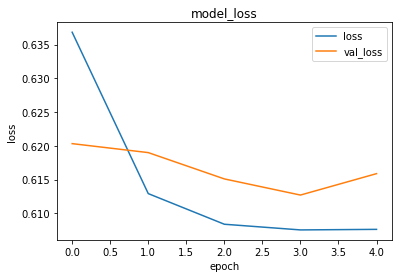

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [11]:
movie_df = pd.read_csv(movielens_dir / 'movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
np. set_printoptions(threshold=np. inf)
print(len(user_movie_array))
print(user_movie_array)
ratings = model.predict(user_movie_array).flatten()
print("This is return array")
print(len(ratings))
print(ratings)
top_ratings_indices = ratings.argsort()[-200:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

8781
[[ 602 5804]
 [ 602  481]
 [ 602    1]
 [ 602  482]
 [ 602  483]
 [ 602  484]
 [ 602  485]
 [ 602 5017]
 [ 602  486]
 [ 602  487]
 [ 602 1399]
 [ 602  488]
 [ 602 3678]
 [ 602  489]
 [ 602 2657]
 [ 602  492]
 [ 602 3604]
 [ 602  493]
 [ 602 2163]
 [ 602  494]
 [ 602  496]
 [ 602  497]
 [ 602 3938]
 [ 602  259]
 [ 602 8955]
 [ 602 3939]
 [ 602 1859]
 [ 602 6704]
 [ 602  498]
 [ 602 5992]
 [ 602  499]
 [ 602  971]
 [ 602 4192]
 [ 602  500]
 [ 602    3]
 [ 602 1400]
 [ 602 5596]
 [ 602    4]
 [ 602 4529]
 [ 602 3811]
 [ 602  501]
 [ 602 3679]
 [ 602 3635]
 [ 602 3940]
 [ 602  502]
 [ 602  503]
 [ 602 1290]
 [ 602 5832]
 [ 602 1401]
 [ 602  505]
 [ 602  506]
 [ 602 6684]
 [ 602 4035]
 [ 602 2663]
 [ 602 4663]
 [ 602 5550]
 [ 602 4698]
 [ 602 2420]
 [ 602 5018]
 [ 602  507]
 [ 602 2421]
 [ 602  508]
 [ 602 6915]
 [ 602 4036]
 [ 602 5687]
 [ 602 4432]
 [ 602  509]
 [ 602  510]
 [ 602  511]
 [ 602  512]
 [ 602  513]
 [ 602  514]
 [ 602 2431]
 [ 602  515]
 [ 602 8152]
 [ 602 9533]
 [ 602 

This is return array
8781
[0.5740863  0.5328153  0.5199433  0.47194234 0.45569053 0.48299214
 0.49450418 0.49848783 0.5551365  0.57444894 0.43334448 0.51350737
 0.5946936  0.4896699  0.5803755  0.40135008 0.44814655 0.51463205
 0.5029775  0.49593732 0.55594814 0.5066908  0.5546714  0.50802577
 0.5477264  0.5672297  0.4769703  0.5501587  0.59290576 0.4962843
 0.50851846 0.40355796 0.5192656  0.47851044 0.6678679  0.48407018
 0.5036735  0.7288764  0.5530374  0.51958495 0.50184643 0.56639826
 0.5449902  0.56493366 0.5234064  0.5725348  0.5675214  0.4904414
 0.47435895 0.44313616 0.49683467 0.5137408  0.5277068  0.6084546
 0.462356   0.5345848  0.55150604 0.57327837 0.4743583  0.5398745
 0.53607947 0.45505527 0.57645106 0.5033428  0.5119631  0.5022694
 0.58794725 0.46135378 0.4837562  0.51368153 0.4566015  0.4635962
 0.57901114 0.43529755 0.5399849  0.5537296  0.52325284 0.49199972
 0.4473506  0.4737963  0.46257085 0.5108888  0.5334265  0.52371573
 0.52148145 0.563388   0.50308454 0.505237

In [12]:



print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 603
Movies with high ratings from user
--------------------------------
eXistenZ (1999) : Action|Sci-Fi|Thriller
Boys Don't Cry (1999) : Drama
Five Easy Pieces (1970) : Drama
Do the Right Thing (1989) : Drama
Place in the Sun, A (1951) : Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Seven (a.k.a. Se7en) (1995) : Mystery|Thriller
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Apollo 13 (1995) : Adventure|Drama|IMAX
Little Princess, A (1995) : Children|Drama
Madness of King George, The (1994) : Comedy|Drama
Murder in the First (1995) : Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Lion King, The (1994) : Adventure|Animation|Children|Drama|Musical|IMAX
In the Name of the Father (1993) : Drama
Terminator 2: Judgment Day (1991) : Action|Sci-Fi
Wallace & Gromit: The Best of Aardman Animation (1996) : Adventure|Animation|Comedy
Ghost in the Shell (Kôkaku kidôtai) (1995) : Anim

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('temp.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\itsho\AppData\Local\Temp\tmp43s7exud\assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path="coverted_model.tflite")

In [ ]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.randint(100,1000,input_shape), dtype=np.int64)
input_data[:,0] = 45
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Movie score",output_data)